# TRABALHANDO NA BASE DE DADOS DO PIB (OCDE)

Neste notebook trabalharemos com a base de dados dos países da OCDE, adquiridos no https://stats.oecd.org/. Deve-se buscar em National Acounts -> Quarterly National Acounts -> Quarterly National Acounts. Como a OCDE fornece dados trimestrais, vamos transformar em dados semestrais. Também adicionaremos dados adicionais, como o continente de cada pais, o número de habitantes por pais, a idade média de cada país,ambos fornecidos pelo site: https://www.worldometers.info/world-population/population-by-country/ e o numero de pessoas por continente https://worldpopulationreview.com/continents.

Primeiro importaremos as bibliotecas que necessitamos para esse estudo:

In [2]:
#Importando as bibliotecas nessessarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import chart_studio as cht
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
init_notebook_mode(connected=True)
import pycountry_convert as pc
import tabula
import camelot
import re
import PyPDF2

path='../../Bases/GDP_SEMESTRE/'

ModuleNotFoundError: No module named 'cufflinks'

Depois, necessitamos ler as bases de dados, tanto a da OCDE quanto da populacao dos continentes e dos países

In [141]:
#Lendo as bases de dados
gdp = pd.read_excel(path +'GBP_semestre.xlsx')
population_country=pd.read_excel(path +'population_country.xlsx')
population_continent=pd.read_excel(path +'population_continent.xlsx')
death_per_capta = pd.read_excel(path +'deaths.xlsx')
fbkf = pd.read_excel(path +'FBKF_semestre.xlsx')
prod_ind = pd.read_excel(path + 'producao_industrial.xlsx')


#Lendo e arrumando df do populismo
file = 'file:///C:/Users/ypmor/OneDrive/Documentos/2020/Mestrado/Disciplina%20economia/Artigos/Populismo/High%20Tide%20Populism%20in%20Power%201990-2020.pdf'
populismo_bruto = camelot.read_pdf(file,pages='19-22')
populismo_df = pd.DataFrame()
populismo_df = pd.concat([populismo_bruto[0].df,populismo_bruto[1].df,populismo_bruto[2].df,populismo_bruto[3].df], ignore_index=True)
populismo = pd.DataFrame()
for i in range(len(populismo_df[0])):
    if populismo_df.loc[i][2][len(populismo_df.loc[i][2])-1] == '-':
        populismo=populismo.append(populismo_df.loc[i])
populismo.rename(columns={0:'País',1:'Presidente',2:'Ano mandato',3:'Tipo populismo'},inplace=True)


#Arrumando df prod industrial
prod_ind ['Q3-2019-mel']=100
prod_ind ['Q4-2019-mel']=prod_ind['Q4-2019']+100
prod_ind ['Q1-2020-mel']=(prod_ind['Q4-2019-mel'])*(1+(prod_ind['Q1-2020']/100))
prod_ind['Q2-2020-mel']=(prod_ind['Q1-2020-mel'])*(1+(prod_ind['Q2-2020']/100))
prod_ind['Variacao Prod Ind (%)'] = (((prod_ind['Q1-2020-mel']+ prod_ind['Q2-2020-mel'])*100)/(prod_ind['Q3-2019-mel']+ prod_ind['Q4-2019-mel']))-100
prod_ind_final=pd.DataFrame()
prod_ind_final['Country']=prod_ind['Country']
prod_ind_final['Variacao Prod Ind (%)'] = prod_ind['Variacao Prod Ind (%)']

Agora, vamos analisar algumas informacoes de cada base de dados:

# DataFrame: Países com líderes populistas

In [114]:
#pedindo informações relevantes das bases de dados e imprimindo o head()
populismo.info()
populismo

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 4 to 47
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   País            17 non-null     object
 1   Presidente      17 non-null     object
 2   Ano mandato     17 non-null     object
 3   Tipo populismo  17 non-null     object
dtypes: object(4)
memory usage: 1.3+ KB


País                   Presidente  \
4          Belarus         Alexander Lukashenko   
7           Brazil               Jair Bolsonaro   
8         Bulgaria                Boyko Borisov   
10  Czech Republic                 Andrej Babiš   
16         Hungary        Viktor Orbán / Fidesz   
17           India                Narendra Modi   
18          Israel           Benjamin Netanyahu   
21           Italy           Five Star Movement   
24          Mexico  Andrés Manuel López Obrador   
25       Nicaragua                Daniel Ortega   
29     Philippines              Rodrigo Duterte   
31          Poland        Law and Justice Party   
33          Serbia             Aleksandar Vučić   
39       Sri Lanka           Gotabaya Rajapaksa   
43          Turkey         Recep Tayyip Erdoğan   
44   United States                 Donald Trump   
47       Venezuela               Nicolás Maduro   

                        Ano mandato      Tipo populismo  
4                             1994-  Anti-establishment  
7                             2019-            Cultural  
8   2009-2013, \n2014-2017, \n2017-  Anti-establishment  
10                            2017-  Anti-establishment  
16                            2010-            Cultural  
17                            2014-            Cultural  
18               1996-1999, \n2009-            Cultural  
21                            2019-  Anti-establishment  
24                            2018-      Socio-economic  
25                            2007-      Socio-economic  
29                            2016-            Cultural  
31               2005-2010, \n2015-            Cultural  
33               2014-2017, \n2017-            Cultural  
39                            2019-            Cultural  
43                            2003-            Cultural  
44                            2017-            Cultural  
47                            2013-      Socio-economic

# DataFrame: População por país

Temos 235 paises na lista, que constam com dados de populacao, densidade,idade média, porcentagem da população urbana, entre outros.

In [52]:
#pedindo informações relevantes das bases de dados e imprimindo o head()
population_country.info()
population_country

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pais             235 non-null    object 
 1   Population       235 non-null    float64
 2   Yearly  Change   235 non-null    object 
 3   Net Change       235 non-null    object 
 4   Density (P/Km²)  235 non-null    float64
 5   Land Area (Km²)  235 non-null    object 
 6   Migrants (net)   201 non-null    float64
 7   Fert. Rate       235 non-null    object 
 8   Med. Age         235 non-null    object 
 9   Urban Pop %      235 non-null    object 
 10  World Share      235 non-null    object 
dtypes: float64(3), object(8)
memory usage: 20.3+ KB


Pais    Population Yearly  Change  Net Change  \
0               China  1.439324e+09         0.39 %   5,540,090   
1               India  1.380004e+09         0.99 %  13,586,631   
2       United States  3.310027e+08         0.59 %   1,937,734   
3           Indonesia  2.735236e+08         1.07 %   2,898,047   
4            Pakistan  2.208923e+08         2.00 %   4,327,022   
..                ...           ...            ...         ...   
230        Montserrat  4.992000e+00         0.06 %           3   
231  Falkland Islands  3.480000e+00         3.05 %         103   
232              Niue  1.626000e+00         0.68 %          11   
233           Tokelau  1.357000e+00         1.27 %          17   
234          Holy See  8.010000e+02         0.25 %           2   

     Density (P/Km²) Land Area (Km²)  Migrants (net) Fert. Rate Med. Age  \
0            153.000       9,388,211        -348.399        1.7       38   
1            464.000       2,973,190        -532.687        2.2       28   
2             36.000       9,147,420         954.806        1.8       38   
3            151.000       1,811,570         -98.955        2.3       30   
4            287.000          770.88        -233.379        3.6       23   
..               ...             ...             ...        ...      ...   
230           50.000             100             NaN       N.A.     N.A.   
231            0.000           12.17             NaN       N.A.     N.A.   
232            6.000             260             NaN       N.A.     N.A.   
233          136.000              10             NaN       N.A.     N.A.   
234            2.003               0             NaN       N.A.     N.A.   

    Urban Pop % World Share  
0          0.61     18.47 %  
1          0.35     17.70 %  
2          0.83      4.25 %  
3          0.56      3.51 %  
4          0.35      2.83 %  
..          ...         ...  
230         0.1      0.00 %  
231        0.66      0.00 %  
232        0.46      0.00 %  
233           0      0.00 %  
234        N.A.      0.00 %  

[235 rows x 11 columns]

#  DataFrame: PIB por país

Já para os dados da OCDE, temos 45 países, com o PIB por semestre em milhoes de dolares de 2015.

In [4]:
#pedindo informações relevantes das bases de dados e imprimindo o head()
gdp.info()
gdp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  45 non-null     object 
 1   Unit     45 non-null     object 
 2   S1-2018  45 non-null     float64
 3   S2-2018  45 non-null     float64
 4   S1-2019  45 non-null     float64
 5   S2-2019  45 non-null     float64
 6   S1-2020  45 non-null     float64
dtypes: float64(5), object(2)
memory usage: 2.6+ KB


Country                       Unit     S1-2018     S2-2018  \
0         Australia  US Dollar, Millions, 2015   2399587.0   2417443.4   
1           Austria  US Dollar, Millions, 2015    919855.7    927884.7   
2           Belgium  US Dollar, Millions, 2015   1089707.1   1097499.2   
3            Canada  US Dollar, Millions, 2015   3375179.0   3406470.6   
4             Chile  US Dollar, Millions, 2015    869925.2    877016.6   
5          Colombia  US Dollar, Millions, 2015   1327850.9   1347006.2   
6    Czech Republic  US Dollar, Millions, 2015    791867.1    801616.2   
7           Denmark  US Dollar, Millions, 2015    597971.3    605066.2   
8           Estonia  US Dollar, Millions, 2015     86860.5     88574.9   
9           Finland  US Dollar, Millions, 2015    501215.9    503001.8   
10           France  US Dollar, Millions, 2015   5706262.0   5751552.2   
11          Germany  US Dollar, Millions, 2015   8271962.8   8278186.7   
12           Greece  US Dollar, Millions, 2015    597425.4    603250.1   
13          Hungary  US Dollar, Millions, 2015    581833.5    595842.8   
14          Iceland  US Dollar, Millions, 2015     37106.4     37719.4   
15          Ireland  US Dollar, Millions, 2015    778591.7    795384.9   
16           Israel  US Dollar, Millions, 2015    658616.9    666955.3   
17            Italy  US Dollar, Millions, 2015   4658219.3   4660889.1   
18            Japan  US Dollar, Millions, 2015  10600552.2  10563689.2   
19      South Korea  US Dollar, Millions, 2015   4199141.0   4254663.0   
20           Latvia  US Dollar, Millions, 2015    106857.5    109621.8   
21        Lithuania  US Dollar, Millions, 2015    183917.4    187503.5   
22       Luxembourg  US Dollar, Millions, 2015    129511.7    129967.8   
23           Mexico  US Dollar, Millions, 2015   4779004.7   4781514.5   
24      Netherlands  US Dollar, Millions, 2015   1828391.4   1841687.5   
25      New Zealand  US Dollar, Millions, 2015    377099.7    381932.4   
26           Norway  US Dollar, Millions, 2015    655103.4    661326.4   
27           Poland  US Dollar, Millions, 2015   2296604.5   2350120.9   
28         Portugal  US Dollar, Millions, 2015    662631.9    669647.3   
29  Slovak Republic  US Dollar, Millions, 2015    351805.9    358008.7   
30         Slovenia  US Dollar, Millions, 2015    145900.9    148817.4   
31            Spain  US Dollar, Millions, 2015   3504113.9   3544453.3   
32           Sweden  US Dollar, Millions, 2015   1025159.3   1030506.8   
33      Switzerland  US Dollar, Millions, 2015   1127333.3   1127631.5   
34           Turkey  US Dollar, Millions, 2015   4693163.1   4561018.1   
35   United Kingdom  US Dollar, Millions, 2015   5799513.3   5855148.1   
36    United States  US Dollar, Millions, 2015  38904438.1  39303488.1   
37        Argentina  US Dollar, Millions, 2015   1721573.8   1666676.8   
38           Brazil  US Dollar, Millions, 2015   5973205.1   6003534.2   
39         Bulgaria  US Dollar, Millions, 2015    288791.5    294180.9   
40            India  US Dollar, Millions, 2015  17054555.0  17508839.7   
41        Indonesia  US Dollar, Millions, 2015   6068916.2   6222766.8   
42          Romania  US Dollar, Millions, 2015    990244.6   1015208.2   
43           Russia  US Dollar, Millions, 2015   7341027.2   7395112.5   
44     South Africa  US Dollar, Millions, 2015   1418664.2   1429364.5   

       S1-2019     S2-2019     S1-2020  
0    2438661.1   2467051.8   2381040.8  
1     937778.8    936662.1    855903.4  
2    1104576.2   1113348.5   1011840.9  
3    3434104.8   3459851.7   3194209.3  
4     886198.4    878597.1    827049.7  
5    1367634.7   1394428.5   1267781.8  
6     810963.3    818650.7    758950.1  
7     612347.8    618904.5    586916.0  
8      91219.0     92824.0     88209.2  
9     507959.9    507742.8    488112.5  
10   5808896.7   5819304.8   5094331.7  
11   8321950.6   8325840.9   7761759.5  
12    610979.9    612125.8    562667.2  
13    612829.5    622857.7    577

#  DataFrame: População por continente

Temos 6 continentes, que constam com dados de populacao, densidade,taxa de crescimento, etc.

In [5]:
#pedindo informações relevantes das bases de dados e imprimindo o head()
population_continent.info()
population_continent

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cont                6 non-null      object 
 1   populacao           6 non-null      int64  
 2   World's Population  6 non-null      object 
 3   Growth Rate         6 non-null      object 
 4   Density (km²)       6 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 368.0+ bytes


cont   populacao World's Population Growth Rate  Density (km²)
0           Asia  4641054775             59.54%       0.86%         104.11
1         Africa  1340598147             17.20%       2.49%          44.24
2         Europe   747636026              9.59%       0.06%          33.78
3  South America   430759766              5.53%       0.83%          24.15
4  North America   368869647              4.73%       0.62%          14.93
5        Oceania    42677813              0.55%       1.31%           5.03

# DataFrame: Morte per capta

Temos dados para 168 países, nos interessamos aqui pela coluna de morte per capita.

In [6]:
death_per_capta.info()
death_per_capta

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   COUNTRY          168 non-null    object 
 1   CONFIRMED        168 non-null    object 
 2   DEATHS           168 non-null    float64
 3   CASE-FATALITY    168 non-null    object 
 4   DEATHS/100K POP  168 non-null    float64
dtypes: float64(2), object(3)
memory usage: 6.7+ KB


COUNTRY  CONFIRMED   DEATHS CASE-FATALITY  DEATHS/100K POP
0          San Marino        732   42.000          5.7%           124.32
1                Peru    821.564   32.609          4.0%           101.94
2             Belgium    130.235   10.064          7.7%            88.11
3             Bolivia    136.868    8.101          5.9%            71.35
4              Brazil  4,915,289  146.352          3.0%            69.87
..                ...        ...      ...           ...              ...
163  Papua New Guinea        540    7.000          1.3%             0.08
164         Sri Lanka      3.402   13.000          0.4%             0.06
165          Tanzania        509   21.000          4.1%             0.04
166           Vietnam      1.096   35.000          3.2%             0.04
167           Taiwan*        517    7.000          1.4%             0.03

[168 rows x 5 columns]

# Transformando a base de dados da OCDE

Vamos modificar a base de dados da OCDE. Os semestres deixarão de ser multiplas colunas para se tornarem apenas uma. Isso facilitará a análise dos dados. Faremos isso com a função melt. Vamos imprimir a base de dados para ver como ficou.

In [142]:
#transformando a base de dados da OCDE do PIB
gdp_continuo=gdp.melt(id_vars=["Country",'Unit'], 
        var_name="Date", 
        value_name="Value")
gdp_continuo.info()
gdp_continuo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  225 non-null    object 
 1   Unit     225 non-null    object 
 2   Date     225 non-null    object 
 3   Value    225 non-null    float64
dtypes: float64(1), object(3)
memory usage: 7.2+ KB


Country                       Unit     Date       Value
0       Australia  US Dollar, Millions, 2015  S1-2018   2399587.0
1         Austria  US Dollar, Millions, 2015  S1-2018    919855.7
2         Belgium  US Dollar, Millions, 2015  S1-2018   1089707.1
3          Canada  US Dollar, Millions, 2015  S1-2018   3375179.0
4           Chile  US Dollar, Millions, 2015  S1-2018    869925.2
..            ...                        ...      ...         ...
220         India  US Dollar, Millions, 2015  S1-2020  16120615.2
221     Indonesia  US Dollar, Millions, 2015  S1-2020   6298873.2
222       Romania  US Dollar, Millions, 2015  S1-2020    995890.6
223        Russia  US Dollar, Millions, 2015  S1-2020   7247364.3
224  South Africa  US Dollar, Millions, 2015  S1-2020   1301307.9

[225 rows x 4 columns]

Agora criaremos algumas funções para passarmos os dados adicionais para a tabela da OCDE. Vamos precisar de uma função conversor, que converte o nome do país e retorna de que continente ele pertence, para podermos criar a coluna Continente. Também precisaremos de uma função que retorna a quantidade populacional de cada continente, para criarmos a coluna no dataFrame chamada Populacao Continente. Por último, criaremos uma função que recebe o nome do país e retorna o seu número populacional para criarmos a coluna População Pais. Também faremos isso para o número de mortes per capta e para a proporção de pessoas em cada país na zona urbana.

In [144]:
#Criando a função conversor e population_continent e criando uma lista com o numero populacional dos paises selecionados
def conversor(name):
    continent_name=''
    country_code = pc.country_name_to_country_alpha2(name, cn_name_format="default")
    continent_code = pc.country_alpha2_to_continent_code(country_code)
    
    if continent_code == 'OC':
        continent_name='Oceania'
    elif continent_code == 'SA':
        continent_name='Am. Sul'
    elif continent_code == 'EU':
        continent_name='Europa'
    elif continent_code == 'AS':
        continent_name='Asia'
    elif continent_code == 'NA':
        continent_name='Am. Norte'
    elif continent_code == 'AF':
        continent_name='Africa'
    else:
        continent_name='Other'
    return continent_name


def get_population_continent(continent_name):
    if continent_name == 'Oceania':
        return 42677813

    elif continent_name == 'Am. do Sul':
        return 430759766

    elif continent_name == 'Europa':
        return 747636026

    elif continent_name == 'Asia':
        return 4641054775

    elif continent_name == 'Am. Norte':
        return 368869647

    elif continent_name == 'Africa':
        return 1340598147
    else:
        return 0

populacao_paises=[]
for pais1 in gdp_continuo['Country']:
    for pais2 in population_country['Pais']:
        if pais1==pais2:
            pop=population_country[(population_country['Pais']==pais2)].iloc[0]['Population']
            populacao_paises.append(pop)
            
mortes_paises=[]
for pais1 in gdp_continuo['Country']:
    for pais2 in death_per_capta['COUNTRY']:
        if pais1==pais2:
            death=death_per_capta[(death_per_capta['COUNTRY']==pais2)].iloc[0]['DEATHS/100K POP']
            mortes_paises.append(death)
            
urban_pop_paises=[]
for pais1 in gdp_continuo['Country']:
    for pais2 in population_country['Pais']:
        if pais1==pais2:
            urban_pop=population_country[(population_country['Pais']==pais2)].iloc[0]['Urban Pop %']*100
            urban_pop_paises.append(urban_pop)
            
def sigla(name):
    paises_importantes=['United Kingdom','Mexico','Italy','Spain','Portugal','Germany','France','Belgium']
    soberano='Brazil'
    if name in paises_importantes:
        return name
    elif name in soberano:
        return name.upper()
    else:
        return pc.country_name_to_country_alpha2(name, cn_name_format="default")
    
def populista(name):
    if name in list(populismo['País']):
        return 'Sim'
    else:
        return 'Não'
    
prod_ind_paises=[]
for pais1 in gdp_continuo['Country']:
    for pais2 in prod_ind_final['Country']:
        if pais1==pais2:
            prod_industrial=prod_ind_final[(prod_ind_final['Country']=='Brazil')]['Variacao Prod Ind (%)']
            prod_ind_paises.append(prod_industrial) 
            
          

In [140]:
prod_ind_final[(prod_ind_final['Country']=='Brazil')]['Variacao Prod Ind (%)']

31   -10.56973
Name: Variacao Prod Ind (%), dtype: float64

In [145]:
# Criando as colunas no dataframe GDP_continuo
gdp_continuo['Continente'] = gdp_continuo['Country'].apply(conversor)
gdp_continuo['Populacao continente'] = gdp_continuo['Continente'].apply(get_population_continent)
gdp_continuo['Populacao Pais']=populacao_paises
gdp_continuo['DEATHS/100K POP']=mortes_paises
gdp_continuo['Urban Population %']=urban_pop_paises
gdp_continuo['sigla']=gdp_continuo['Country'].apply(sigla)
gdp_continuo['Populismo']=gdp_continuo['Country'].apply(populista)
gdp_continuo['Variacao Prod Ind %']=prod_ind_paises

ValueError: Length of values (7425) does not match length of index (225)

# Definição do semestre base, para comparação percentual:

Nossa ideia aqui é estabelecer o ultimo semestre de 2019 (S2-2019) como 1, e os restantes dos semestres, tanto para frente quanto para trás de S2-2019 temporalmente, ficarão com valores relativos a esse semestre base. Isso permite comparar como o primeiro semestre de 2020 se diferenciou do final do ultimo ano.

In [123]:
data_frame=pd.DataFrame()
for pais in gdp['Country']:
    
    valor_mes_base_do_pais = gdp_continuo[(gdp_continuo['Country']==pais) & (gdp_continuo['Date']=='S2-2019')]['Value'].reset_index().loc[0]['Value']
    todos_valores_do_pais = gdp_continuo[gdp_continuo['Country']==pais]['Value']
    index=todos_valores_do_pais/valor_mes_base_do_pais
    data_frame=data_frame.append(index)
    
            
data_frame=data_frame.transpose().sort_index()
data_frame=data_frame.mean(axis=1)
data_frame=data_frame.rename('Valor percentual (max 1)')
gdp_continuo = gdp_continuo.join(data_frame)
gdp_continuo.head()

Country                       Unit     Date      Value Continente  \
0  Australia  US Dollar, Millions, 2015  S1-2018  2399587.0    Oceania   
1    Austria  US Dollar, Millions, 2015  S1-2018   919855.7     Europa   
2    Belgium  US Dollar, Millions, 2015  S1-2018  1089707.1     Europa   
3     Canada  US Dollar, Millions, 2015  S1-2018  3375179.0  Am. Norte   
4      Chile  US Dollar, Millions, 2015  S1-2018   869925.2    Am. Sul   

   Populacao continente  Populacao Pais  DEATHS/100K POP  Urban Population %  \
0              42677813      25499884.0             3.58                86.0   
1             747636026       9006398.0             9.19                57.0   
2             747636026      11589623.0            88.11                98.0   
3             368869647      37742154.0            25.72                81.0   
4                     0      19116201.0            69.30                85.0   

     sigla Populismo  Valor percentual (max 1)  
0       AU       Não                  0.972654  
1       AT       Não                  0.982057  
2  Belgium       Não                  0.978765  
3       CA       Não                  0.975527  
4       CL       Não                  0.990130

# Definindo os países mais afetados pela COVID-19

O critério que definimos para os paises mais afetados foi os 10+ do número de mortes per capta para aqueles países com população maior do que 100.000 habitantes, que extraimos do site da johns hopkins: https://coronavirus.jhu.edu/data/mortality. Dessa forma, criamos a função afetados, que retorna um tipo true or false, mas para facilitar, retorna a string "sim" ou "nao".

In [124]:
#Criando a funcao para definir se foi afetado ou nao. Se o pais tiver na lista abaixo, ele esta entre os 10+ afetados.
def afetados(pais):
    p=['Brazil','United States','Ecuador','Spain','Mexico','United Kingdom','Peru','Chile','Belgium','Bolivia']
    if pais in p:
        return 'Sim'
    else:
        return 'Não'

#Criando uma coluna no dataframe para se foi afetado ou nao pela covid
    
gdp_continuo['Pais gravemente afetado pela covid-19'] = gdp_continuo['Country'].apply(afetados)

In [125]:
gdp_continuo.head()

Country                       Unit     Date      Value Continente  \
0  Australia  US Dollar, Millions, 2015  S1-2018  2399587.0    Oceania   
1    Austria  US Dollar, Millions, 2015  S1-2018   919855.7     Europa   
2    Belgium  US Dollar, Millions, 2015  S1-2018  1089707.1     Europa   
3     Canada  US Dollar, Millions, 2015  S1-2018  3375179.0  Am. Norte   
4      Chile  US Dollar, Millions, 2015  S1-2018   869925.2    Am. Sul   

   Populacao continente  Populacao Pais  DEATHS/100K POP  Urban Population %  \
0              42677813      25499884.0             3.58                86.0   
1             747636026       9006398.0             9.19                57.0   
2             747636026      11589623.0            88.11                98.0   
3             368869647      37742154.0            25.72                81.0   
4                     0      19116201.0            69.30                85.0   

     sigla Populismo  Valor percentual (max 1)  \
0       AU       Não                  0.972654   
1       AT       Não                  0.982057   
2  Belgium       Não                  0.978765   
3       CA       Não                  0.975527   
4       CL       Não                  0.990130   

  Pais gravemente afetado pela covid-19  
0                                   Não  
1                                   Não  
2                                   Sim  
3                                   Não  
4                                   Sim

# DataFrame: Comparativo do PIB s2-2019/s1-2020

Agora que temos o valor percentual da mudança de S1-2020 em comparacao com s2-2019, podemos ver quanto foi a diferença entre um e outro ao subtrair 1 da variacao percentual de S1-2020. Ficaremos assim com a variação (para os paises analisados todos tiveram variacao negativa do pib no S1-2020.

In [126]:
gdp_comparation=gdp_continuo[gdp_continuo['Date']=='S1-2020']
gdp_comparation.reset_index(inplace=True)
gdp_comparation.drop('index',axis=1,inplace=True)
gdp_comparation['Variação negativa do PIB (%)'] = (gdp_comparation["Valor percentual (max 1)"]-1).abs()*100
gdp_comparation.sort_values('Variação negativa do PIB (%)',inplace=True)
gdp_comparation.dropna(inplace=True)
gdp_comparation.sort_values('Variação negativa do PIB (%)',inplace=True,ascending=False)
gdp_comparation

Country                       Unit     Date       Value  \
31            Spain  US Dollar, Millions, 2015  S1-2020   3119595.8   
10           France  US Dollar, Millions, 2015  S1-2020   5094331.7   
37        Argentina  US Dollar, Millions, 2015  S1-2020   1455310.1   
35   United Kingdom  US Dollar, Millions, 2015  S1-2020   5206597.2   
17            Italy  US Dollar, Millions, 2015  S1-2020   4125105.1   
40            India  US Dollar, Millions, 2015  S1-2020  16120615.2   
28         Portugal  US Dollar, Millions, 2015  S1-2020    614449.9   
23           Mexico  US Dollar, Millions, 2015  S1-2020   4283456.7   
30         Slovenia  US Dollar, Millions, 2015  S1-2020    137689.4   
2           Belgium  US Dollar, Millions, 2015  S1-2020   1011840.9   
5          Colombia  US Dollar, Millions, 2015  S1-2020   1267781.8   
29  Slovak Republic  US Dollar, Millions, 2015  S1-2020    332845.1   
44     South Africa  US Dollar, Millions, 2015  S1-2020   1301307.9   
1           Austria  US Dollar, Millions, 2015  S1-2020    855903.4   
12           Greece  US Dollar, Millions, 2015  S1-2020    562667.2   
14          Iceland  US Dollar, Millions, 2015  S1-2020     35477.2   
3            Canada  US Dollar, Millions, 2015  S1-2020   3194209.3   
13          Hungary  US Dollar, Millions, 2015  S1-2020    577296.2   
6    Czech Republic  US Dollar, Millions, 2015  S1-2020    758950.1   
38           Brazil  US Dollar, Millions, 2015  S1-2020   5651716.1   
11          Germany  US Dollar, Millions, 2015  S1-2020   7761759.5   
33      Switzerland  US Dollar, Millions, 2015  S1-2020   1077616.6   
20           Latvia  US Dollar, Millions, 2015  S1-2020    104463.7   
25      New Zealand  US Dollar, Millions, 2015  S1-2020    366395.3   
4             Chile  US Dollar, Millions, 2015  S1-2020    827049.7   
24      Netherlands  US Dollar, Millions, 2015  S1-2020   1769074.4   
36    United States  US Dollar, Millions, 2015  S1-2020  37992629.3   
18            Japan  US Dollar, Millions, 2015  S1-2020  10048584.7   
42          Romania  US Dollar, Millions, 2015  S1-2020    995890.6   
16           Israel  US Dollar, Millions, 2015  S1-2020    653969.9   
7           Denmark  US Dollar, Millions, 2015  S1-2020    586916.0   
8           Estonia  US Dollar, Millions, 2015  S1-2020     88209.2   
22       Luxembourg  US Dollar, Millions, 2015  S1-2020    127470.8   
27           Poland  US Dollar, Millions, 2015  S1-2020   2325333.9   
34           Turkey  US Dollar, Millions, 2015  S1-2020   4506139.7   
15          Ireland  US Dollar, Millions, 2015  S1-2020    815778.8   
39         Bulgaria  US Dollar, Millions, 2015  S1-2020    290166.4   
32           Sweden  US Dollar, Millions, 2015  S1-2020   1002392.5   
9           Finland  US Dollar, Millions, 2015  S1-2020    488112.5   
41        Indonesia  US Dollar, Millions, 2015  S1-2020   6298873.2   
26           Norway  US Dollar, Millions, 2015  S1-2020    645422.4   
0         Australia  US Dollar, Millions, 2015  S1-2020   2381040.8   
43           Russia  US Dollar, Millions, 2015  S1-2020   7247364.3   
21        Lithuania  US Dollar, Millions, 2015  S1-2020    189706.6   
19      South Korea  US Dollar, Millions, 2015  S1-2020   4250285.9   

   Continente  Populacao continente  Populacao Pais  DEATHS/100K POP  \
31     Europa             747636026    4.675478e+07            68.67   
10     Europa             747636026    6.527351e+07            48.03   
37    Am. Sul                     0    4.519577e+07            47.24   
35     Europa             747636026    6.788601e+07            63.83   
17     Europa             747636026    6.046183e+07            59.55   
40       Asia            4641054775    1.380004e+09             7.52   
28     Europa             747636026    1.019671e+07            19.50   
23  Am. Norte             368869647    1.289328e+08            62.67   
30     Europa             747636026    2.078938e+06             7.50   
2      Europa            

# Gráfico: Declínio econômico por país

Para efeitos do gráfico que construiremos a seguir, criarei uma coluna só para selecionar o Brasil, para poder imprimir no gráfico com uma cor diferente. Depois impriremos o resultado final para vizualização.

In [127]:
# Função para definir o valor da variacao do pib do brasil numa outra coluna
def brazil(name):
    if name=='Brazil':
        return gdp_comparation['Variação negativa do PIB (%)'].loc[38]
    else:
        return 0
gdp_comparation['Brazil']=gdp_comparation['Country'].apply(brazil)

Text(0, -50, 'Fonte: OCDE statistics; IBGE. Elaboração própria.\n\nNota:Os valores brutos do PIB por país estão\nem dólares de 2015 e já sazonalizados\npela própria OCDE.')

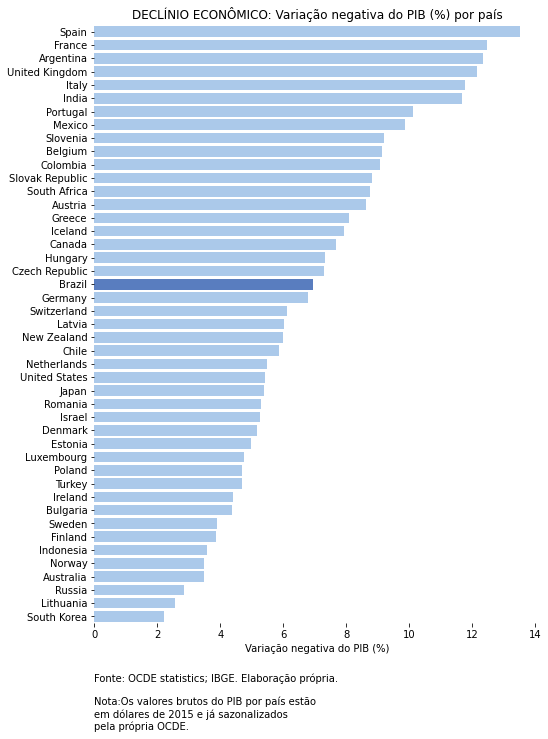

In [128]:
# Criando o primeiro gráfico, os paises com a variacao negativa do PIB
f, ax = plt.subplots(figsize=(8, 11))


# f.suptitle("COVID-19 economic impact")

sns.set_color_codes("pastel")
sns.barplot(x="Variação negativa do PIB (%)", y="Country", data=gdp_comparation, color="b")

sns.set_color_codes("muted")
sns.barplot(x="Brazil", y="Country", data=gdp_comparation, color="b")

sns.despine(left=True, bottom=True)

ax.set(title="DECLÍNIO ECONÔMICO: Variação negativa do PIB (%) por país")
ax.set(ylabel='',xlabel='Variação negativa do PIB (%)')
annotation = """Fonte: OCDE statistics; IBGE. Elaboração própria.\n\nNota:Os valores brutos do PIB por país estão
em dólares de 2015 e já sazonalizados
pela própria OCDE."""

ax.annotate(annotation, (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [129]:
# deletamos da base de dados a coluna que criamos apenas para o grafico acima.
gdp_comparation.drop('Brazil',axis=1, inplace=True)

# Gráfico: Análise dos Continentes

Vamos fazer uma analise dos continentes. Primeiro, buscamos ordenar os dados por continentes para verificar quantos países temos em cada continente. Analizaremos tambem um boxplot para sabermos um pouco mais como cada continente sofreu economicamente.

In [63]:
#Organizando os valores por continente
gdp_comparation.sort_values('Continente',inplace=True)

In [67]:
#Checando o numero de países por continente
gdp_comparation['Continente'].value_counts()

Europa       29
Asia          6
Am. Sul       4
Am. Norte     3
Oceania       2
Africa        1
Name: Continente, dtype: int64

Text(0, -50, 'Fonte: OCDE statistics. Elaboração própria.\n\nNota: Foram considerados 6 países da Ásia, 29 países da Europa, \n3 países da América do Norte, 4 países da América do Sul, 2 países\nda Oceania e apenas 1 país da Africa. Os valores brutos do PIB por país estão\nem dólares de 2015 e já sazonalizados pela própria OCDE.')

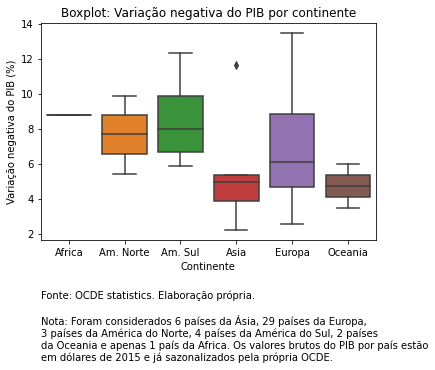

In [21]:
# Initialize the matplotlib figure
# f.suptitle("COVID-19 economic impact")
ax = sns.boxplot(y="Variação negativa do PIB (%)", x='Continente', data=gdp_comparation)
ax.set(title="Boxplot: Variação negativa do PIB por continente")
ax.set(ylabel='Variação negativa do PIB (%)')
annotation = """Fonte: OCDE statistics. Elaboração própria.\n
Nota: Foram considerados 6 países da Ásia, 29 países da Europa, 
3 países da América do Norte, 4 países da América do Sul, 2 países
da Oceania e apenas 1 país da Africa. Os valores brutos do PIB por país estão
em dólares de 2015 e já sazonalizados pela própria OCDE."""

ax.annotate(annotation, (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')

# Gráfico: Declinio PIB e mortes per capta por país

Após uma analise geral por continente, vamos selecionar agora por pais. Como queremos analisar o declinio economico e a gravidade da covid, escolhemos o gráfico que relaciona essas duas variáveis. Chegamos a conclusão que os países se dividem em dois grupos gerais, que demonstram dois comportamentos distintos para o efeito econômico. Esses grupos são: 1- aqueles com mortes per capta igual ou abaixo de 40 por 100 mil habitantes e 2- aqueles com mortes maiores de 40 por 100 mil habitantes.

Text(0, -50, 'Fontes: OCDE stat / Johns Hopkins Coronavirus Resourse Center.\nElaboração própria.\n\n Nota:Os valores do PIB retirados da OCDE estavam em milhões de dólares, anualizados por 2015 e já sazonalizados\npela própria OCDE. Já a Participação do Turismo no PIB refere-se ao PIB do ano de 2019 para os países aqui tratados.\nPor último, os valores do número de mortes por 100 mil habitantes são do dia 06 de setembro.')

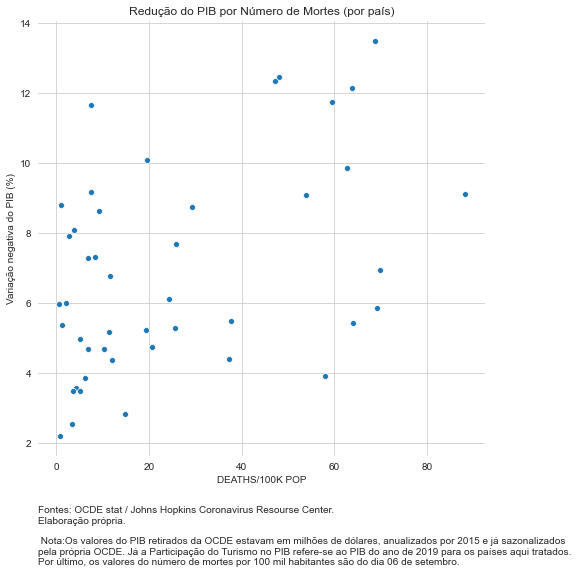

In [133]:
plt.figure(figsize=(8,8))
sns.set_style('whitegrid')
y=gdp_comparation['Variação negativa do PIB (%)']
x=gdp_comparation['DEATHS/100K POP']
ax = sns.scatterplot(data=gdp_comparation,y='Variação negativa do PIB (%)',x='DEATHS/100K POP')
ax.set(title="Redução do PIB por Número de Mortes (por país)")

annotation = """Fontes: OCDE stat / Johns Hopkins Coronavirus Resourse Center.\nElaboração própria.
\n Nota:Os valores do PIB retirados da OCDE estavam em milhões de dólares, anualizados por 2015 e já sazonalizados
pela própria OCDE. Já a Participação do Turismo no PIB refere-se ao PIB do ano de 2019 para os países aqui tratados.
Por último, os valores do número de mortes por 100 mil habitantes são do dia 06 de setembro."""


sns.despine(left=True, bottom=True)
ax.annotate(annotation, (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')

Text(0, -50, 'Fontes: World Travel & Tourism / OCDE stat / Johns Hopkins Coronavirus Resourse Center.\nElaboração própria.\n\n Nota:Os valores do PIB retirados da OCDE estavam em milhões de dólares, anualizados por 2015 e já sazonalizados\npela própria OCDE. Já a Participação do Turismo no PIB refere-se ao PIB do ano de 2019 para os países aqui tratados.\nPor último, os valores do número de mortes por 100 mil habitantes são do dia 06 de setembro.')

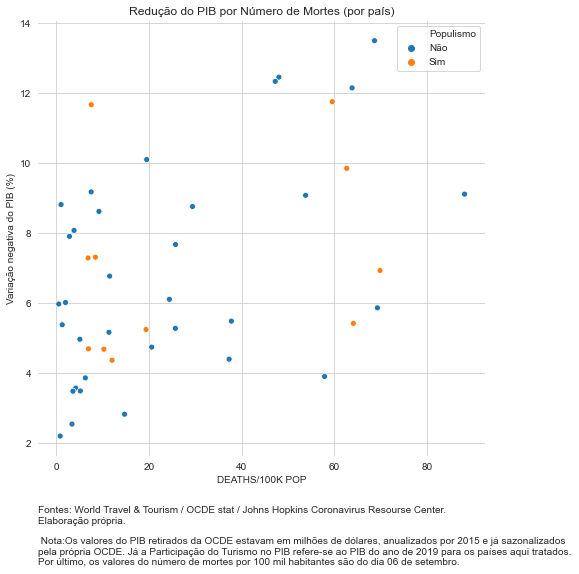

In [131]:
plt.figure(figsize=(8,8))
sns.set_style('whitegrid')
y=gdp_comparation['Variação negativa do PIB (%)']
x=gdp_comparation['DEATHS/100K POP']
ax = sns.scatterplot(data=gdp_comparation,y='Variação negativa do PIB (%)',x='DEATHS/100K POP',hue='Populismo')
ax.set(title="Redução do PIB por Número de Mortes (por país)")

annotation = """Fontes: OCDE stat / Johns Hopkins Coronavirus Resourse Center / .\nElaboração própria.
\n Nota:Os valores do PIB retirados da OCDE estavam em milhões de dólares, anualizados por 2015 e já sazonalizados
pela própria OCDE. Já a Participação do Turismo no PIB refere-se ao PIB do ano de 2019 para os países aqui tratados.
Por último, os valores do número de mortes por 100 mil habitantes são do dia 06 de setembro."""


sns.despine(left=True, bottom=True)
ax.annotate(annotation, (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')

# Separando os países em grupos (mortes per capta)

Para separarmos os países, necessitamos criar uma função que defina esses grupos pelo critério escolhido.Depois de criarmos a coluna, criamos um DataFrame somente para o grupo A e outro para o grupo B. Dessa forma, podemos comparar alguns atributos dos dois grupos, como por exemplo o número médio de queda do PIB para cada grupo 

In [23]:
# Criando uma nova coluna para separar os paises com mortes acima de 40 e os abaixo
def grupos(num):
    if num<=40:
        return 'Países com menos mortes'
    else:
        return 'Países com mais mortes'
gdp_comparation['Grupo de Países']=gdp_comparation['DEATHS/100K POP'].apply(grupos)

Text(0, -50, 'Fonte: OCDE statistics. Elaboração própria.\n\nNota: Foram considerados 6 países da Ásia, 29 países da Europa, \n3 países da América do Norte, 4 países da América do Sul, 2 países\nda Oceania e apenas 1 país da Africa. Os valores brutos do PIB por país estão\nem dólares de 2015 e já sazonalizados pela própria OCDE.')

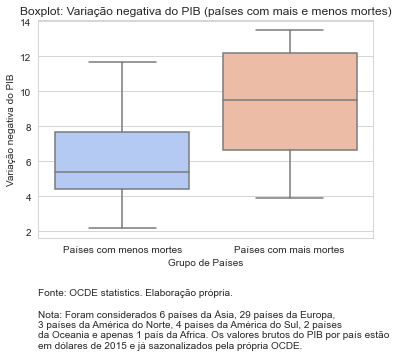

In [24]:
# Initialize the matplotlib figure
# f.suptitle("COVID-19 economic impact")
sns.set_palette("bright")
ax = sns.boxplot(y="Variação negativa do PIB (%)", x='Grupo de Países', data=gdp_comparation,palette="coolwarm")
ax.set(title="Boxplot: Variação negativa do PIB (países com mais e menos mortes)")
ax.set(ylabel='Variação negativa do PIB')
annotation = """Fonte: OCDE statistics. Elaboração própria.\n
Nota: Foram considerados 6 países da Ásia, 29 países da Europa, 
3 países da América do Norte, 4 países da América do Sul, 2 países
da Oceania e apenas 1 país da Africa. Os valores brutos do PIB por país estão
em dólares de 2015 e já sazonalizados pela própria OCDE."""

ax.annotate(annotation, (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')

In [25]:
#Separando em dois dataframes os dois grupos de países
gdp_mais_mortes=gdp_comparation[(gdp_comparation['Grupo de Países']=="Países com mais mortes")]
gdp_menos_mortes=gdp_comparation[(gdp_comparation['Grupo de Países']=="Países com menos mortes")]

In [26]:
#Verificando o describe do grupo com mais mortes
gdp_mais_mortes.describe()

Value  Populacao continente  Populacao Pais  DEATHS/100K POP  \
count  1.200000e+01          1.200000e+01    1.200000e+01         12.00000   
mean   5.919817e+06          4.352963e+08    8.747956e+07         62.75500   
std    1.026665e+07          3.505960e+08    9.509808e+07         11.06168   
min    8.270497e+05          0.000000e+00    1.009926e+07         47.24000   
25%    1.203797e+06          0.000000e+00    3.867588e+07         56.86750   
50%    3.622350e+06          5.582528e+08    5.567236e+07         63.25000   
75%    5.122398e+06          7.476360e+08    8.314770e+07         68.82750   
max    3.799263e+07          7.476360e+08    3.310027e+08         88.11000   

       Urban Population %  Valor percentual (max 1)  \
count           12.000000                 12.000000   
mean            84.416667                  0.906340   
std              7.204271                  0.032028   
min             69.000000                  0.865000   
25%             81.500000                  0.878017   
50%             83.500000                  0.905143   
75%             88.000000                  0.933318   
max             98.000000                  0.960928   

       Variação negativa do PIB (%)  
count                     12.000000  
mean                       9.365977  
std                        3.202782  
min                        3.907239  
25%                        6.668211  
50%                        9.485714  
75%                       12.198318  
max                       13.499951

In [27]:
#Verificando o describe do grupo com menos mortes
gdp_menos_mortes['Variação negativa do PIB (%)'].describe()

Value  Populacao continente  Populacao Pais  DEATHS/100K POP  \
count  3.300000e+01          3.300000e+01    3.300000e+01        33.000000   
mean   2.348787e+06          1.419296e+09    7.443466e+07        11.687879   
std    3.547506e+06          1.556780e+09    2.410278e+08        10.487203   
min    3.547720e+04          4.267781e+07    3.412430e+02         0.510000   
25%    3.663953e+05          7.476360e+08    5.421241e+06         3.810000   
50%    7.589501e+05          7.476360e+08    9.660351e+06         7.520000   
75%    2.381041e+06          7.476360e+08    3.784661e+07        19.350000   
max    1.612062e+07          4.641055e+09    1.380004e+09        37.770000   

       Urban Population %  Valor percentual (max 1)  \
count           33.000000                 33.000000   
mean            73.787879                  0.940374   
std             14.079590                  0.023010   
min             35.000000                  0.883287   
25%             66.000000                  0.923221   
50%             74.000000                  0.946158   
75%             86.000000                  0.955982   
max             94.000000                  0.977946   

       Variação negativa do PIB (%)  
count                     33.000000  
mean                       5.962638  
std                        2.301004  
min                        2.205367  
25%                        4.401781  
50%                        5.384216  
75%                        7.677855  
max                       11.671305